In [1]:
from pulp import *
import numpy as np
import matplotlib.pyplot as plt

In [3]:
taskset = [{'period':6, 'deadline':6, 'computation':2},
          {'period':9, 'deadline':9, 'computation':2},
          {'period':12, 'deadline':8, 'computation':2},
          {'period':18, 'deadline':10, 'computation':4}]

In [5]:
f = 4 # frame size hardcoded for now
P = np.lcm.reduce([t['period'] for t in taskset]) #hyperperiod
tasks, frames = range(len(taskset)), range(P//f)

In [7]:
model = LpProblem('cyclic_executive', LpMaximize)
b_frames = LpVariable.dicts('F', [(i, t) for i in frames for t in tasks], cat='Binary')
phases = LpVariable.dicts('Phi', range(len(taskset)), lowBound=0,cat='Integer')

In [9]:
# dummy objective function since this is a constraint satisfaction problem
model += lpSum([taskset[t]['computation'] * b_frames[(f, t)] for f in frames for t in tasks])

# Now adding constraints

#each frame cannot have more computations than its size
for i in frames:
    model += lpSum([b_frames[(i,t)] * taskset[t]['computation'] for t in tasks]) <= f 

# each task instance is executed in a frame which starts no earlier than its arrival, and ends no later than its deadline
for t, task in enumerate(taskset):
    for i in frames:
        model += lpSum([b_frames[(j,t)] for j in frames[:i+1]]) <= (i*f - phases[t])/task['period'] +1
        model += lpSum([b_frames[(j,t)] for j in frames[:i+1]]) >= ((i+2)*f - task['deadline']  - phases[t])/task['period']
    

In [11]:
solution = model.solve()
print("Phases are ", ["Phi_%d = %d"%(t, phases[t].value()) for t in tasks])
for i in frames:
    print("Frame ", i, ["Task %d"%t for t in tasks if b_frames[(i,t)].value()>0] )

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/rahmed/anaconda3/envs/schlib/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/c1b6f0d7fd4045549badfeb431f5e5cd-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/c1b6f0d7fd4045549badfeb431f5e5cd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 86 COLUMNS
At line 671 RHS
At line 753 BOUNDS
At line 794 ENDATA
Problem MODEL has 81 rows, 40 columns and 468 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 36 - 0.00 seconds
Cgl0004I processed model has 45 rows, 40 columns (40 integer (36 of which binary)) and 252 elements
Cutoff increment increased from 1e-05 to 1.9999
Cbc0038I Initial state - 14 integers unsatisfied sum - 5
Cbc0038I Pass   1: suminf.    2.00000 (7) obj. -30.8889 iterations 21
Cbc0038I Pass   2: suminf.    1.55556 (4) obj. -33.1111 it

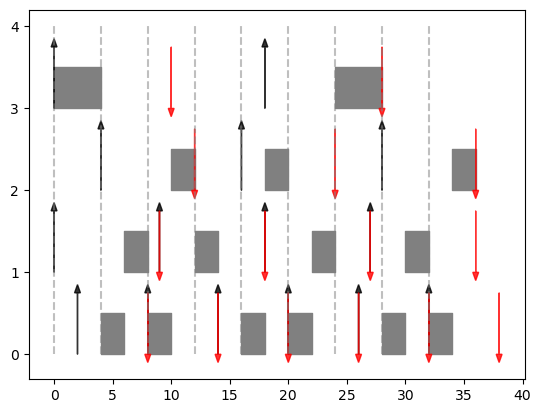

OrderedDict([('_C1',
              2*F_(0,_0) + 2*F_(0,_1) + 2*F_(0,_2) + 4*F_(0,_3) + -4 <= 0),
             ('_C2',
              2*F_(1,_0) + 2*F_(1,_1) + 2*F_(1,_2) + 4*F_(1,_3) + -4 <= 0),
             ('_C3',
              2*F_(2,_0) + 2*F_(2,_1) + 2*F_(2,_2) + 4*F_(2,_3) + -4 <= 0),
             ('_C4',
              2*F_(3,_0) + 2*F_(3,_1) + 2*F_(3,_2) + 4*F_(3,_3) + -4 <= 0),
             ('_C5',
              2*F_(4,_0) + 2*F_(4,_1) + 2*F_(4,_2) + 4*F_(4,_3) + -4 <= 0),
             ('_C6',
              2*F_(5,_0) + 2*F_(5,_1) + 2*F_(5,_2) + 4*F_(5,_3) + -4 <= 0),
             ('_C7',
              2*F_(6,_0) + 2*F_(6,_1) + 2*F_(6,_2) + 4*F_(6,_3) + -4 <= 0),
             ('_C8',
              2*F_(7,_0) + 2*F_(7,_1) + 2*F_(7,_2) + 4*F_(7,_3) + -4 <= 0),
             ('_C9',
              2*F_(8,_0) + 2*F_(8,_1) + 2*F_(8,_2) + 4*F_(8,_3) + -4 <= 0),
             ('_C10', 1*F_(0,_0) + 0.16666666666666666*Phi_0 + -1.0 <= 0),
             ('_C11',
              1*F_(0,_0) + 0.1

In [17]:
# now drawing the schedule and printing constraints
fig, sch = plt.subplots()

sch.vlines(np.array(frames) * f, 0, 4, linestyles='dashed', color='gray', alpha =0.5)

for i in frames:
    start = i *f
    for t in tasks:
        if b_frames[(i,t)].value():
            sch.broken_barh([(start, taskset[t]['computation'])], (t,0.5 ), color = 'gray')
            start += taskset[t]['computation']
for t, task in enumerate(taskset):
    arrivals = np.arange(P/task['period']) * task['period'] + phases[t].value()
    deadlines = arrivals + task['deadline']
    for a in arrivals:
        sch.arrow(a,t, 0,0.75, color = 'black', head_width=0.5, head_length=0.1, alpha =0.8)
    for d in deadlines:
        sch.arrow(d,t+0.75, 0,-0.75, color = 'red', head_width=0.5, head_length=0.1, alpha=0.8)   
plt.show()
model.constraints